In [2]:
#Other good imports                        
from numpy.linalg import matrix_power                                                                       
from iminuit import Minuit                                                                 
from scipy.integrate import quad
import sympy as sp
from sympy import integrate , print_latex
import pandas as pd
from IPython.display import display


#Packages needed for the external functions
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import roc_curve, auc
from iminuit.util import make_func_code
from iminuit import describe 


# import sequence of functions from external file
import sys 
sys.path.append('../MyExternalFunctions')
from MyExternalFunctions import *

Matplotlib_settings()

### MatPlotLib settings:

In [3]:
import matplotlib.pyplot as plt
import numpy as np
def Matplotlib_settings():
    plt.style.use('classic')
    plt.rcParams['font.family'] = 'Times New Roman'
    # plt.rcParams['figure.dpi'] = 500
    plt.rcParams.update({'font.size': 12})
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['grid.color'] = "#cccccc"
    plt.rcParams['lines.color'] = "k"
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['lines.markersize'] = 8
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['figure.titlesize'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['xtick.minor.visible'] = True
    plt.rcParams['ytick.minor.visible'] = True
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['errorbar.capsize'] = 2

Matplotlib_settings()

#### Data generator functions:

In [4]:
#generate data from a poisson distribution
def poisson_data(Lambda,N):
    '''Function for generating data from a poisson distribution
    
       N: number of events
       mu: mean of distribution
       
       returns: array of data'''
    data = np.random.poisson(Lambda, N)  
    return data , ax



#generate data from a gaussian distribution
def gaussian_data(mu, sigma, N):
    '''Function for generating data from a gaussian distribution
    
       N: number of events
       mu: mean of distribution
       sigma: standard deviation of distribution
       
       returns: array of data'''
    data = np.random.normal(mu, sigma, N)
    return data


#generate data from a binomial distribution
def binomial_data(n, p, N):
    '''Function for generating data from a binomial distribution
    
       N: number of events
       p: probability of success
       
       returns: array of data'''
    data = np.random.binomial(n, p, N)
    return data

In [5]:
data = gaussian_data(1.68,0.06,10000)

ax = easy_hist(data,50)['ax']
ax.axvline(1.73, color='r', linestyle='dashed', linewidth=1)

TypeError: easy_hist() missing 1 required positional argument: 'Nbins'

#### binning / histogram function: 

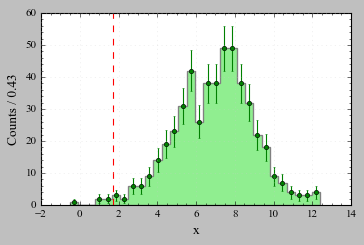

In [ ]:
#Binning function

import numpy as np
def binning(x, xrange, Nbins, remove_empty=True):
    '''Function for binning data and removing empty bins
    
       x: data to be binned
       xrange: range of data in tuble (min, max)
       Nbins: number of bins
       remove_empty_bins: if True, empty bins are removed from
       
       returns: counts, bin_centers, binwidth'''
    binwidth = (xrange[1]-xrange[0])/Nbins
    counts , bin_edges = np.histogram(x, range=xrange, bins=Nbins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

    if remove_empty:
        bin_centers = bin_centers[counts>0]
        counts = counts[counts>0]

    return counts , bin_centers, binwidth
    


#Plotting histogram:

def easy_hist(x, Nbins, Figsize=(5, 3)):
    '''Function for plotting a histogram
    
       x: data to be binned
       xrange: range of data in tuble (min, max)
       Nbins: number of bins
       ax: axis to plot on
       '''
    
    counts, bin_centers, binwidth = binning(x, (min(x),max(x)), Nbins)
    fig, ax = plt.subplots(figsize=Figsize)
    ax.hist(x, bins=Nbins ,range=(min(x),max(x)), histtype='stepfilled', color='lightgreen', edgecolor='grey', linewidth=1.2)
    ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o',ms=4,mec='k',mfc='g', capsize=1, ecolor='g')
    ax.set(xlabel='x', ylabel=f'Counts / {binwidth:.2f}')
    
    return {'counts':counts , 'bin_centers':bin_centers, 'binwidth':binwidth , 'ax':ax}



#example:
x1 = gaussian_data(7, 2,500)
ax = easy_hist(x1, 30)['ax']
ax.axvline(1.73, color='r', linestyle='dashed', linewidth=1)

#### Monte Carlo functions: 

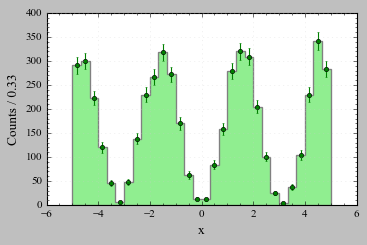

In [ ]:
import numpy as np
import sympy as sp

def Accept_reject(f, xrange, yrange, N_accepted):
    '''Function for generating random numbers according to a given function
       using the accept/reject method.
       
       Input: f, xmin, xmax, ymin, ymax, N_accepted
       
       returns: 
       array of accepted values
       number of tries
       [efficiency, efficiency error]
       [integral, integral error]  
       [normalization, normalization error]'''

    x = sp.Symbol('x')
    f = sp.lambdify(x, f, 'numpy')
       
    r = np.random
    r.seed(42)
    
    N_try = 0
    x_accepted = []
    
    while len(x_accepted) < N_accepted:
        x = r.uniform(*xrange)
        y = r.uniform(*yrange)
        if y < f(x):
            x_accepted.append(x)
        N_try += 1


    eff = N_accepted / N_try 
    eff_err = np.sqrt(eff * (1-eff) / N_try)        # binomial error

    integral =  eff * (xrange[1]-xrange[0]) * (yrange[1]-yrange[0])
    integral_err = eff_err * (xrange[1]-xrange[0]) * (yrange[1]-yrange[0])

    normalization = 1 / integral
    normalization_err = integral_err / integral**2

    return x_accepted, N_try, [eff, eff_err], [integral, integral_err], [normalization, normalization_err]


#example the accept/reject function: 
data = Accept_reject('sin(x)**2', (-5,5), (0,1), 5000)
easy_hist(data[0], 30, Figsize=(5, 3));

In [ ]:
# inverse transform method:

import sympy as sp
def inverse_transform(f,N, xmin, xmax=None):
    '''Function for generation random numbers according to the inverse transformation method using sympy.
    
       Input: f: function given as a string 
              N: number of point 
              xmin: lower limit of integration
              xmax: (optional) = infinity as default'''

    if xmax == None:
        xmax = sp.oo
    
    x, y = sp.symbols('x y')
    F_norm = sp.integrate(f, (x, xmin, xmax), conds='none')

    if F_norm == 0:
        print('ERROR: Integral is zero. Choose a different integration range.')
        return
    if F_norm == sp.oo:
        print('ERROR: Integral is diverging. Choose a different integration range.')
        return

    F = 1/F_norm * sp.integrate(f, (x, xmin, x), conds='none')
    F_inv = sp.solve(F-y, x)[0]
    F_inv = sp.lambdify(y, F_inv, 'numpy')
    r = np.random
    r.seed(42)
    y = r.uniform(0,1,N)
    x_values = F_inv(y)

    return x_values , F_norm, F_inv

### Fisher Discriminant function: 

In [10]:
# fisher discriminant function:

import numpy as np

def fisher_2var(sample1, sample2, w0=True):
    """
    Calculates Fisher discriminants given two samples with the w0 correction term as default.
    
    Parameters:
        sample1 (numpy array): the first sample
        sample2 (numpy array): the second sample
        w0 (bool): if True, the w0 correction term is calculated
    
    Returns:
        (float): the calculated Fisher discriminant
    """
    mean1 = np.mean(sample1, axis=0)
    mean2 = np.mean(sample2, axis=0)
    cov1 = np.cov(sample1, rowvar=False)
    cov2 = np.cov(sample2, rowvar=False)
    
    cov_combined = cov1 + cov2
    inv_cov_combined = np.linalg.inv(cov_combined)

    wf = inv_cov_combined @ (mean1 - mean2)

    if w0:
        w0 = - np.sum(wf)

    fisher1 = sample1 @ wf + w0 
    fisher2 = sample2 @ wf + w0

    std_1 = np.std(sample1, ddof=1)
    std_2 = np.std(sample2, ddof=1)
    separation = np.abs((mean1 - mean2)) / np.sqrt(std_1**2 + std_2**2)

    return fisher1, fisher2, separation


In [23]:
def fisher_3var(sample1, sample2, w0=True):
    import numpy as np
    # Mean vectors
    mean1 = np.mean(sample1, axis=0)
    mean2 = np.mean(sample2, axis=0)

    cov1 = np.cov(sample1.T)
    cov2 = np.cov(sample2.T)

    cov_combined = cov1 + cov2
    inv_cov_combined = np.linalg.inv(cov_combined)

    wf = inv_cov_combined @ (mean1 - mean2)
    

    # Within-class scatter matrix
    S1 = np.zeros((3,3))
    S2 = np.zeros((3,3))
    for i in range(len(A1)):
        xi = np.array([A1[i], B1[i], C1[i]])
        S1 += (xi - mean1).dot((xi - mean1).T)
    
    print(S1)

    for i in range(len(A2)):
        xi = np.array([A2[i], B2[i], C2[i]])
        S2 += (xi - mean2).dot((xi - mean2).T)

    print(S2)

    S_w = S1 + S2
    print(S_w)

    # Between-class scatter matrix
    S_b = (mean1 - mean2).dot((mean1 - mean2).T)
    print(S_b)

    # Eigenvectors of the scatter matrices
    eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(S_w).dot(S_b))
    # Fisher discriminant function
    w = eigen_vectors[np.argmax(eigen_values)]
    return w


In [24]:
x1 = np.random.normal(-1, 1, 1000)
y1 = np.random.normal(1, 1, 1000)
z1 = np.random.normal(1, 1, 1000)

x2 = np.random.normal(1, 1, 1000)
y2 = np.random.normal(-1, 1, 1000)
z2 = np.random.normal(-1, 1, 1000)

fisher_3var(x1, y1, z1, x2, y2, z2)
# fish1, fish2, sep = fisher_2var([x1, y1],[x2,y2])

# fish1

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

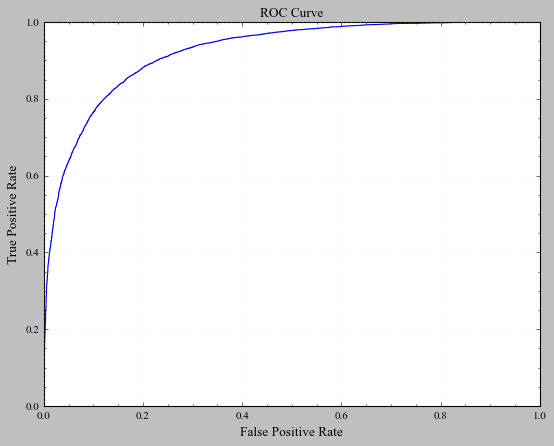

The Area under the ROC curve is 0.923.
The threshold for a false positive rate of 0.1 is 0.269


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

def ROC_curve(sample1, sample2, fpr_cond=None, tpr_cond=None):
    """
    Calculates the ROC curve and the AUC given two samples. 
    Optionally condtions on either the FPR or TPR can be given to calculate the corresponding threshold.
    
    Parameters:
        sample1 (numpy array): the first sample
        sample2 (numpy array): the second sample
    
    Returns:
        (array): the calculated FPR
        (array): the calculated TPR
        (float): the calculated AUC
        (optional) (printed string): the calculated threshold for the given condition 
    """


    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(np.concatenate((np.zeros(len(sample1)), np.ones(len(sample2)))), np.concatenate((x, y)))


    # Plot the ROC curve
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    


    # Calculate the Area Under the Curve (AUC)
    Area = auc(fpr, tpr)   
    print(f'The Area under the ROC curve is {Area:.3f}.') 


    if fpr_cond != None:
        condition_index = np.where(fpr < fpr_cond)[0][-1]
        print(f'The threshold for a false positive rate of {fpr_cond} is {thresholds[condition_index]:.3f}')
        
    
    if tpr_cond != None:
        condition_index = np.where(tpr > tpr_cond)[0][0]
        print(f'The threshold for a true positive rate of {tpr_cond} is {thresholds[condition_index]:.3f}')


    plt.show()
    return fpr, tpr, Area





# Example of the ROC curve function:
# Generate some data for the distributions
x = np.random.normal(-1, 1, 10000)
y = np.random.normal(1, 1, 10000)

fpr, tpr, area = ROC_curve(x, y, fpr_cond=0.1)

In [ ]:



######################################################################  Chi2  ###############################################################



from iminuit.util import make_func_code
from iminuit import describe #, Minuit,

def set_var_if_None(var, x):
    if var is not None:
        return np.array(var)
    else: 
        return np.ones_like(x)
    
def compute_f(f, x, *par):
    try:
        return f(x, *par)
    except ValueError:
        return np.array([f(xi, *par) for xi in x])


#chi2 penelty function

def Chi2penelty(parameter, know_parameter, sigma_parameter):
    '''Function for calculating the penelty term for a given parameter, known parameter and sigma.
    
       Input: parameter, known parameter, sigma
       
       returns: penelty term'''

    return (parameter - know_parameter)**2 / sigma_parameter**2



class Chi2Regression:  # override the class with a better one

    def __init__(self, f, x, y, sy=None, weights=None, bound=None, penelty=None):
        
        if bound is not None:
            x = np.array(x)
            y = np.array(y)
            sy = np.array(sy)
            mask = (x >= bound[0]) & (x <= bound[1])
            x  = x[mask]
            y  = y[mask]
            sy = sy[mask]
            
        

        self.f = f  # model predicts y for given x
        self.x = np.array(x)
        self.y = np.array(y)
        
        self.sy = set_var_if_None(sy, self.x)
        self.weights = set_var_if_None(weights, self.x)
        self.func_code = make_func_code(describe(self.f)[1:])

        # if penelty is None:
        #     self.penelty = 0
        # else:
        #     self.penelty = np.sum(Chi2penelty(*penelty))

    def __call__(self, *par):  # par are a variable number of model parameters
        
        # compute the function value
        f = compute_f(self.f, self.x, *par)
        
        # compute the chi2-value
        chi2 = np.sum(self.weights*(self.y - f)**2/self.sy**2) + 
        
        return chi2



# chi2 prop string med ddof 
from scipy import stats
def Chi2prop(Minuit_object, N_data):
    '''Function for calculating the chi2 probability for a given Minuit object and number of data points.
    
       Input: Minuit object, number of data points
       
       returns: chi2 p-value , string(chi2 / dof = chi2_reduced)'''

    chi2 = Minuit_object.fval
    dof = N_data - Minuit_object.nfit
    p_value = stats.chi2.sf(chi2, dof)

    # string with chi2 / dof = chi2_reduced
    chi2_string = f'{chi2:.2f} / {dof} = {chi2/dof:.2f}'

    return p_value, chi2_string








